**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [1]:
%load_ext autoreload
%autoreload 2
import importlib

import os
import gc
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

from sklearn.metrics import mean_absolute_error, mean_squared_error


from extract_hyperfeatures import load_models

import archs.correspondence_utils
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

def clear_cuda():
    torch.cuda.empty_cache()
    gc.collect()

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\Diffusion_Hyperfeatures\Lib\site-packages\diffusers\pipelines\pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


In [3]:
def process_image(image_pil, res=None, range=(-1, 1)):
    if res:
        image_pil = image_pil.resize(res, Image.BILINEAR)
    image = torchvision.transforms.ToTensor()(image_pil) # range [0, 1]
    r_min, r_max = range[0], range[1]
    image = image * (r_max - r_min) + r_min # range [r_min, r_max]
    return image[None, ...], image_pil

def compute_pck(predicted_points, target_points, load_size, pck_threshold=0.1, target_bounding_box=None):
    distances = np.linalg.norm(predicted_points - target_points, axis=-1)
    if target_bounding_box is None:
        pck = distances <= pck_threshold * max(load_size)
    else:
        left, top, right, bottom = target_bounding_box
        pck = distances <= pck_threshold * max(right-left, bottom-top)
    return distances, pck, pck.sum() / len(pck)

def flatten_feats(feats):
    b, c, w, h = feats.shape
    feats = feats.view((b, c, -1))
    feats = feats.permute((0, 2, 1))
    return feats

def normalize_feats(feats):
    feats = feats / torch.linalg.norm(feats, dim=-1, keepdim=True)
    return feats

def points_to_idxs(points, load_size):
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    points_y = points[:, 0]
    points_y = np.clip(points_y, 0, load_size[1] - 1)
    points_x = points[:, 1]
    points_x = np.clip(points_x, 0, load_size[0] - 1)
    idx = load_size[1] * np.round(points_y) + np.round(points_x)
    return idx.astype(np.int64)

def load_and_compute_hyperfeats(image_path, device, load_size):
    img = Image.open(image_path).convert("RGB")
    proc_img, img_pil = process_image(img, res=load_size)
    proc_img = proc_img.to(device)

    with torch.inference_mode():
        with torch.autocast("cuda"):
            feats, _ = diffusion_extractor.forward(proc_img)
            b, s, l, w, h = feats.shape
            hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
            return hyperfeats

def extract_hyperfeats_for_sources(json_path, image_dir, indices, device, load_size):
    with open(json_path, 'r') as file:
        data = json.load(file)

    hyperfeatures_dict = {}
    points_dict = {}

    for entry in data:
        index = entry['image_path'].split('.')[0]
        if int(index) in indices:
            image_path = os.path.join(image_dir, entry['image_path'])
            hyperfeatures = load_and_compute_hyperfeats(image_path, device, load_size)
            hyperfeatures_dict[index] = hyperfeatures
            points_dict[index] = entry['image_points']

    return hyperfeatures_dict, points_dict

def draw_correspondences_multi(source_images_paths, source_points_dict, predicted_points, target_image_path, title=""):
    num_sources = len(source_points_dict)
    fig, axs = plt.subplots(1, num_sources + 1, figsize=(5 * (num_sources + 1), 5))  # Adjust subplot size dynamically

    # Plot for each source points set
    for idx, (key, source_image_path) in enumerate(source_images_paths.items()):
        image = Image.open(source_image_path)
        axs[idx].imshow(image)  # You might want to display the source image instead if available
        axs[idx].set_title(f"Source Points for Image {key}")
        points = np.array(source_points_dict[key])  # Ensure source_points is a numpy array
        axs[idx].scatter(points[:, 0], points[:, 1], color='red', label='Source Points')
        axs[idx].legend()

    target_image = Image.open(target_image_path)

    # Plot for predicted points
    axs[-1].imshow(target_image)
    axs[-1].set_title("Predicted Points on Target")
    axs[-1].scatter(predicted_points[:, 0], predicted_points[:, 1], color='blue', label='Predicted Points')
    axs[-1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def eval_preds(predictions, ground_truths):
    mae_per_point = []
    mse_per_point = []
    
    for pred_points, gt_points in zip(predictions, ground_truths):
        mae_per_image = []
        mse_per_image = []
        for pred_point, gt_point in zip(pred_points, gt_points):
            mae_per_image.append(mean_absolute_error(gt_point, pred_point))
            mse_per_image.append(mean_squared_error(gt_point, pred_point))
        mae_per_point.append(mae_per_image)
        mse_per_point.append(mse_per_image)
    
    # Average MAE and MSE per image
    avg_mae_per_image = [np.mean(mae_image) for mae_image in mae_per_point]
    avg_mse_per_image = [np.mean(mse_image) for mse_image in mse_per_point]

    # Average MAE and MSE for the entire dataset
    avg_mae_dataset = np.mean(avg_mae_per_image)
    avg_mse_dataset = np.mean(avg_mse_per_image)

    return {
        'mae_per_point': mae_per_point,
        'mse_per_point': mse_per_point,
        'avg_mae_per_image': avg_mae_per_image,
        'avg_mse_per_image': avg_mse_per_image,
        'avg_mae_dataset': avg_mae_dataset,
        'avg_mse_dataset': avg_mse_dataset
    }

In [14]:
importlib.reload(archs.correspondence_utils)
from archs.correspondence_utils import find_nn_multisource_correspondences2, draw_correspondences_multi

def process_images(json_path, image_dir, source_indices, device, load_size, output_json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    load_size = tuple(load_size) if isinstance(load_size, list) else load_size

    # Step 1: Define the source images and calculate their hyperfeatures
    source_hyperfeats = {}
    source_points = {}
    source_image_paths = {}
    for entry in data:
        index = entry['image_path'].split('.')[0]
        if int(index) in source_indices:
            image_path = os.path.join(image_dir, entry['image_path'])
            hyperfeats = load_and_compute_hyperfeats(image_path, device, load_size)
            source_hyperfeats[index] = hyperfeats
            source_points[index] = entry['image_points']
            source_image_paths[index] = image_path

    predictions = []
    ground_truths = []
    evaluation_results = []


    # Step 2: Iterate through the target images
    for idx, target_entry in enumerate(data):
        target_image_path = os.path.join(image_dir, target_entry['image_path'])
        target_hyperfeats = load_and_compute_hyperfeats(target_image_path, device, load_size)

        # Process the target hyperfeatures
        target_hyperfeats = torch.nn.functional.interpolate(target_hyperfeats, size=load_size, mode="bilinear", align_corners=False)
        target_hyperfeats = flatten_feats(target_hyperfeats)
        target_hyperfeats = normalize_feats(target_hyperfeats)

        max_sims = None
        best_points = None

        # Step 3: Iterate through the source images
        for index in source_indices:
            if str(index) in source_hyperfeats:
                img1_feats = source_hyperfeats[str(index)]
                source_points_arr = np.array(source_points[str(index)])

                # Process the source hyperfeatures
                img1_feats = torch.nn.functional.interpolate(img1_feats, size=load_size, mode="bilinear", align_corners=False)
                img1_feats = flatten_feats(img1_feats)
                img1_feats = normalize_feats(img1_feats)

                # Get the indices of the source points
                source_idx = torch.from_numpy(points_to_idxs(source_points_arr, load_size)).long().to(device)
                img1_feats = img1_feats[:, source_idx, :]

                # Calculate the similarity matrix
                sims = torch.matmul(img1_feats, target_hyperfeats.permute((0, 2, 1)))

                if max_sims is None:
                    max_sims = sims
                    best_points = sims.argmax(dim=-1)
                else:
                    current_max_values = sims.max(dim=-1).values
                    better_mask = current_max_values > max_sims.max(dim=-1).values

                    best_points = torch.where(better_mask, sims.argmax(dim=-1), best_points)
                    max_sims = torch.where(better_mask.unsqueeze(-1), sims, max_sims)

        # Convert the best points indices back into image coordinates
        num_pixels = int(math.sqrt(sims.shape[-1]))

        points_x = best_points % num_pixels
        points_y = best_points // num_pixels
        predicted_points = torch.stack([points_y, points_x], dim=-1)

        initial_points = torch.from_numpy(np.array(source_points[str(source_indices[0])]))  # Just take the first source's points for reference
        predicted_points = predicted_points[0]

        predicted_points = predicted_points.cpu().numpy()
        target_points = np.array(target_entry['image_points'])

        predictions.append(predicted_points)
        ground_truths.append(target_points)

        distances, _, pck_metric = compute_pck(predicted_points, target_points, load_size)
        print(f"Source_Points: {source_points}")
        print(f"Pred_p shape {predicted_points.shape}; \n Predicted points {predicted_points}")
        title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \nPCK@0.1: {pck_metric.round(decimals=2)}"
        target_image = Image.open(target_image_path)
        draw_correspondences_multi(source_image_paths, source_points, predicted_points, target_image_path, title=title)
        plt.show()
    
        evaluation_results.append({
            'index': target_entry['image_path'],
            'mae': mean_absolute_error(target_points, predicted_points),
            'mse': mean_squared_error(target_points, predicted_points),
            'pck': pck_metric.item() if isinstance(pck_metric, torch.Tensor) else pck_metric
        })

    with open(output_json_path, 'w') as outfile:
            json.dump(evaluation_results, outfile)

In [17]:
clear_cuda()
image_path = "assets/spair/Biked_Subset"
json_path = "annotations/geopoints_swapped_2.json"
indices = [2,5]
load_size = (256, 256)
output_size = (config["output_resolution"], config["output_resolution"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Select from [nearest_neighbors, best_buddies]
correspondence_function = "nearest_neighbors"

Source_Points: {'2': [[141, 81], [141, 117], [143, 173], [91, 152], [121, 110], [118, 109], [97, 153], [100, 155], [85, 150], [133, 168], [111, 108], [117, 108]], '5': [[141, 77], [143, 119], [141, 179], [88, 157], [119, 112], [118, 111], [95, 160], [99, 161], [86, 162], [132, 173], [110, 110], [115, 110]]}
Pred_p shape (12, 2); 
 Predicted points [[145  77]
 [150 126]
 [145 177]
 [ 90 156]
 [102 107]
 [101 103]
 [ 97 158]
 [100 158]
 [ 85 160]
 [135 171]
 [ 99 102]
 [101 102]]


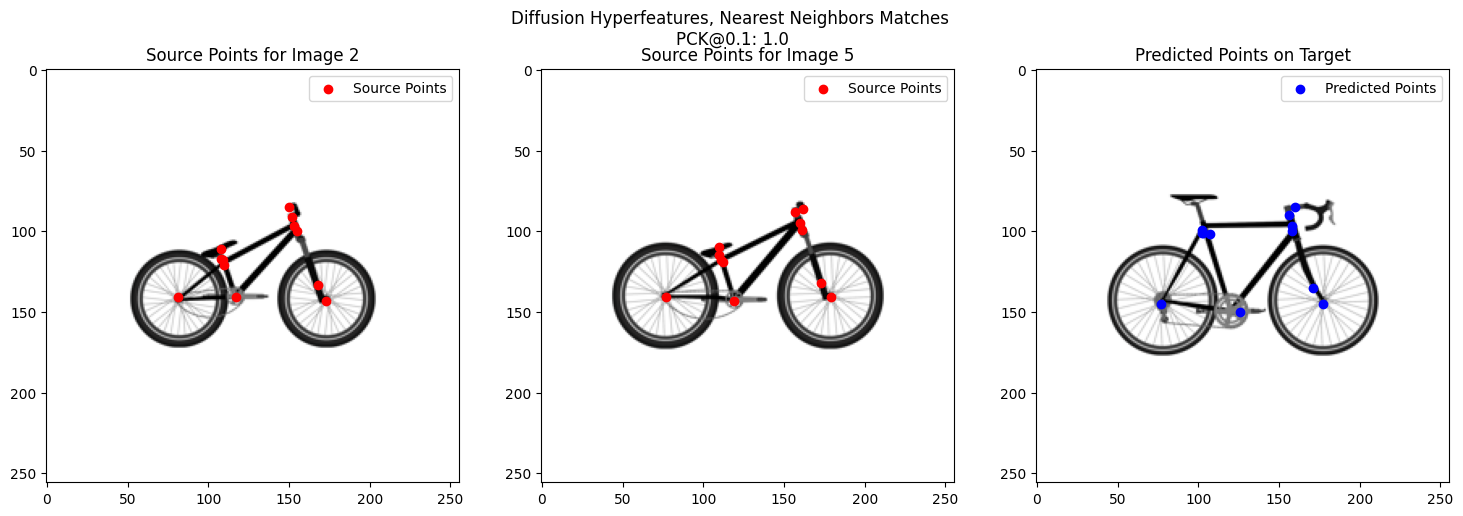

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\archs\aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


Source_Points: {'2': [[141, 81], [141, 117], [143, 173], [91, 152], [121, 110], [118, 109], [97, 153], [100, 155], [85, 150], [133, 168], [111, 108], [117, 108]], '5': [[141, 77], [143, 119], [141, 179], [88, 157], [119, 112], [118, 111], [95, 160], [99, 161], [86, 162], [132, 173], [110, 110], [115, 110]]}
Pred_p shape (12, 2); 
 Predicted points [[141  81]
 [141 117]
 [143 173]
 [ 91 152]
 [121 110]
 [118 109]
 [ 97 153]
 [100 155]
 [ 85 150]
 [133 168]
 [111 108]
 [117 108]]


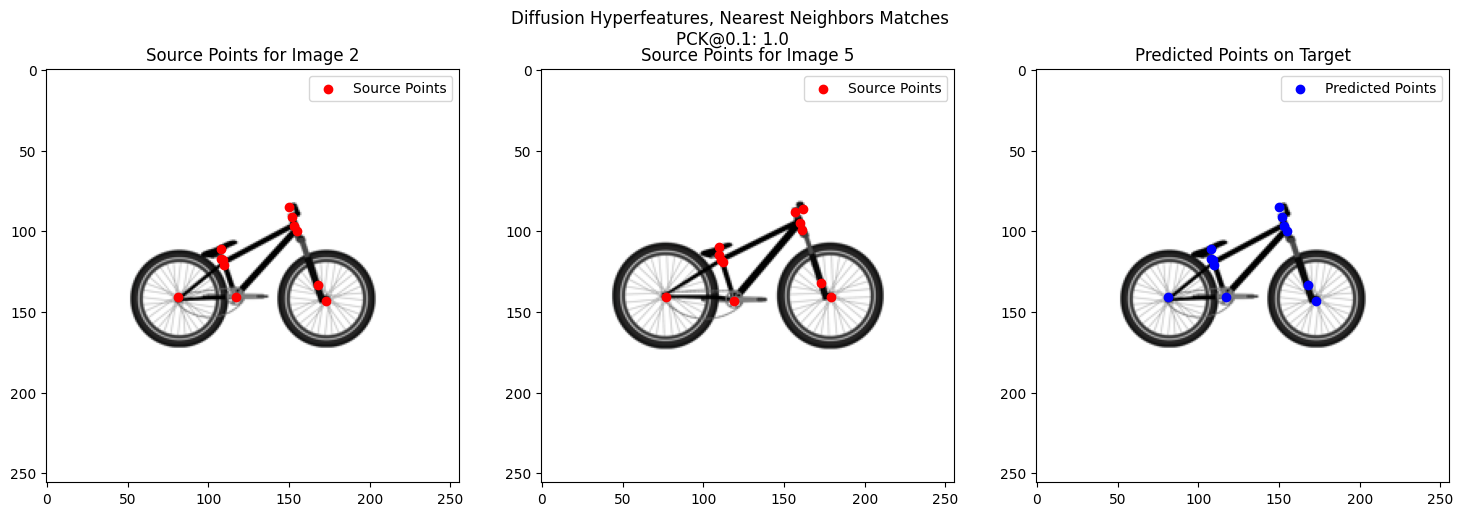

FileNotFoundError: [Errno 2] No such file or directory: 'assets/spair/Biked_Subset\\3.png'

In [18]:
process_images(json_path, image_path, indices, device, load_size, 'results2.json')

In [11]:
source_hyperfeats = hyperfeat_sources(json_path, indices, image_path, device, load_size)
source_points = extract_source_points(json_path, indices)

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\archs\aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


[[144  78]
 [151 120]
 [144 177]
 [ 87 155]
 [ 99 104]
 [ 97 103]
 [ 96 158]
 [102 160]
 [ 85 167]
 [134 171]
 [ 79 102]
 [ 95 102]]


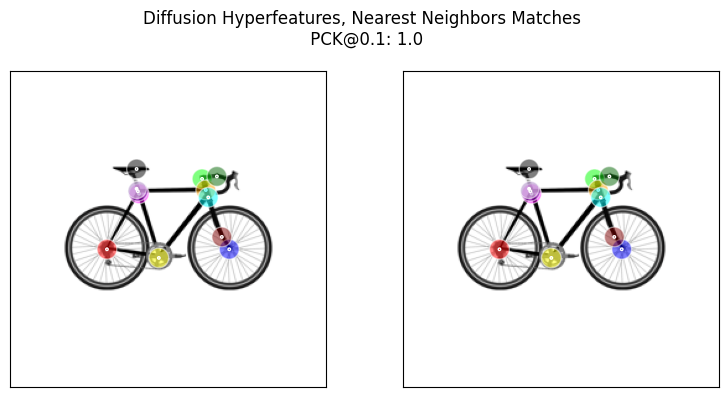

[[143  84]
 [143 119]
 [143 175]
 [ 89 152]
 [118 112]
 [118 112]
 [ 96 153]
 [102 156]
 [ 84 152]
 [134 167]
 [105 106]
 [118 111]]


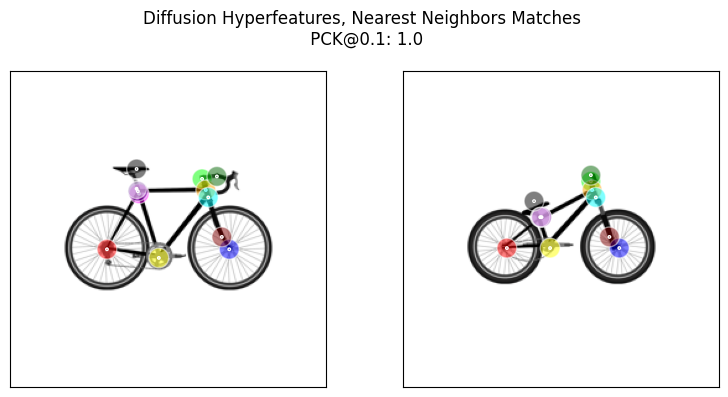

[[150  76]
 [151 115]
 [150 181]
 [ 92 156]
 [103 103]
 [100 102]
 [100 159]
 [108 164]
 [ 87 163]
 [139 175]
 [ 78 101]
 [ 97 102]]


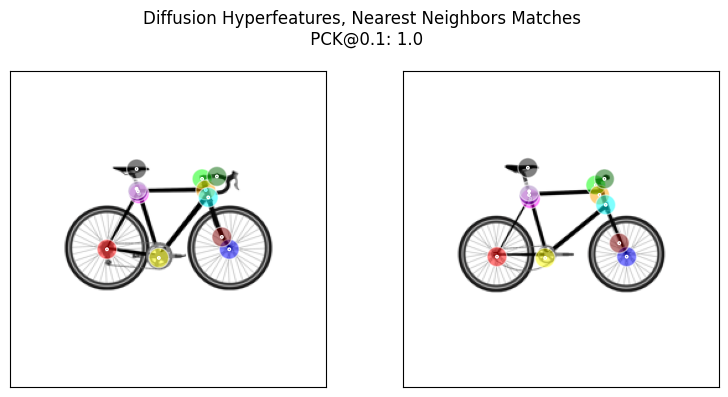

[[141  83]
 [144 120]
 [139 174]
 [ 92 152]
 [102 108]
 [100 105]
 [ 98 155]
 [103 158]
 [ 90 161]
 [129 166]
 [ 86 105]
 [ 99 104]]


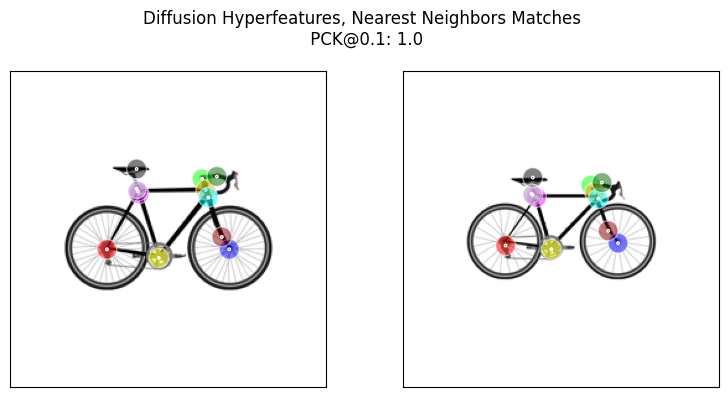

[[143  79]
 [144 119]
 [143 180]
 [ 86 157]
 [117 113]
 [117 113]
 [ 94 159]
 [ 99 162]
 [ 84 160]
 [132 174]
 [105 109]
 [118 112]]


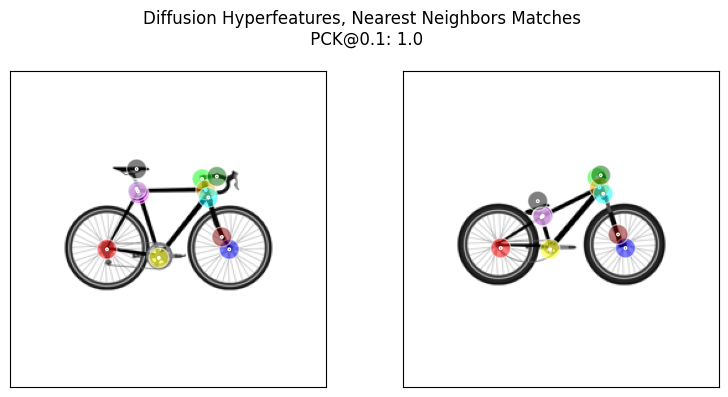

[[148  86]
 [151 119]
 [147 172]
 [102 160]
 [121 109]
 [121 108]
 [109 161]
 [114 163]
 [ 95 164]
 [140 168]
 [111 104]
 [121 107]]


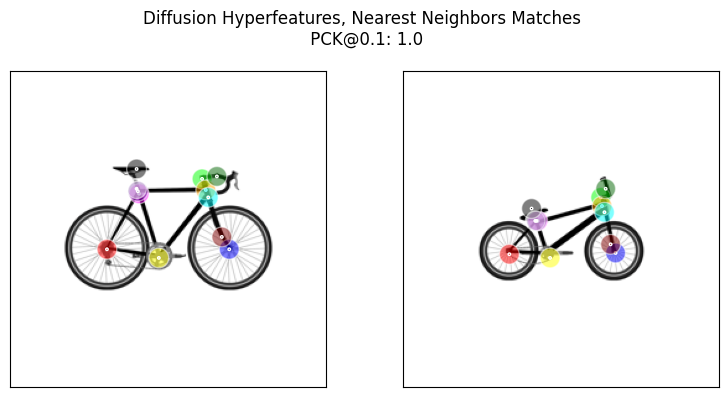

[[149  73]
 [152 115]
 [150 184]
 [ 85 154]
 [104 101]
 [103  99]
 [ 94 158]
 [103 162]
 [ 80 164]
 [141 177]
 [ 80  96]
 [100  97]]


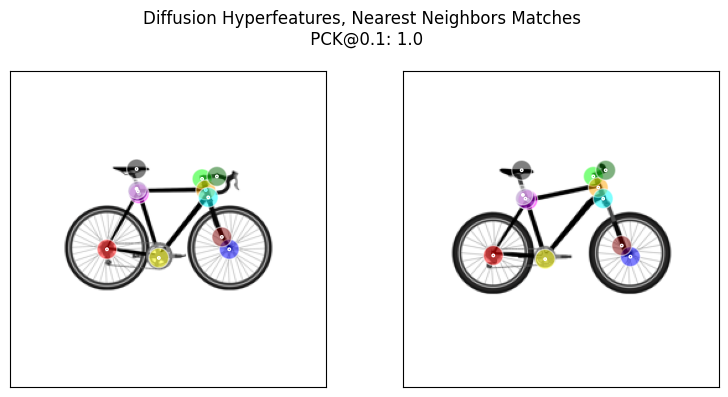

[[145  73]
 [151 115]
 [145 183]
 [ 85 157]
 [104 104]
 [100 101]
 [ 92 159]
 [ 96 161]
 [ 79 163]
 [135 175]
 [ 79  99]
 [ 99 100]]


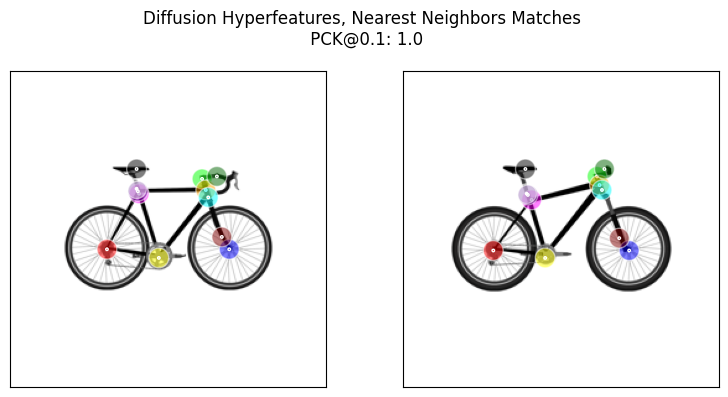

[[143  78]
 [150 120]
 [143 179]
 [ 86 153]
 [103 107]
 [100 105]
 [ 95 158]
 [102 160]
 [ 83 167]
 [133 172]
 [ 81 104]
 [ 97 104]]


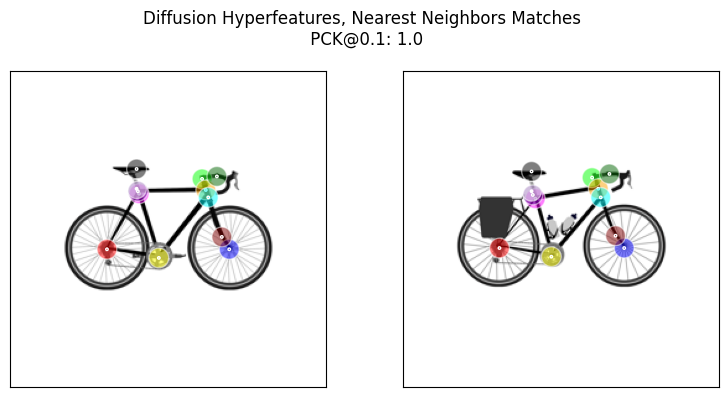

[[143  79]
 [152 121]
 [144 180]
 [ 81 158]
 [103 109]
 [100 108]
 [ 89 160]
 [ 95 163]
 [ 77 164]
 [132 173]
 [ 79 106]
 [ 96 105]]


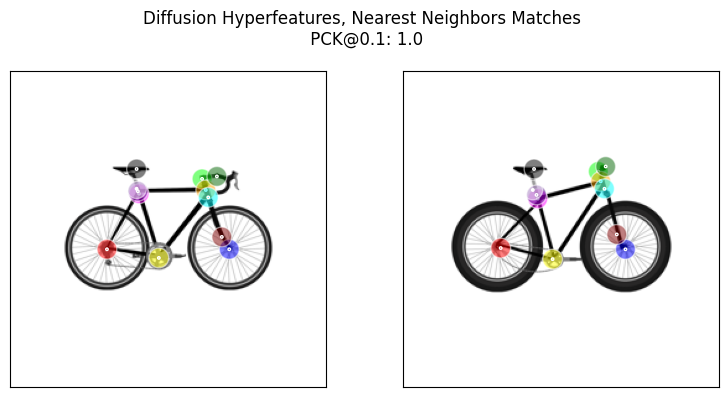

In [54]:
num_iters = 10
with open(json_path, 'r') as file:
  data = json.load(file)
count = 0

for ann in data:
  if count < num_iters:
    target_points, target_img, target_img_pil = load_image(ann, load_size, device, image_path)
    
    with torch.inference_mode():
      with torch.autocast("cuda"):
        t_feats, _ = diffusion_extractor.forward(target_img)
        b, s, l, w, h = t_feats.shape
        t_diffusion_hyperfeats = aggregation_network(t_feats.float().view((b, -1, w, h)))
        t_hyperfeats = t_diffusion_hyperfeats[0][None, ...]

    if correspondence_function == "nearest_neighbors":
      _, predicted_points = find_nn_source_correspondences(source_hyperfeats, t_hyperfeats, source_points, output_size, load_size)
      predicted_points = predicted_points.detach().cpu().numpy()
      print(predicted_points)
      distances, _, pck_metric = compute_pck(predicted_points, target_points, load_size)
      title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \n PCK@0.1: {pck_metric.round(decimals=2)}"

    else:
      raise NotImplementedError
    
    draw_correspondences(source_points, predicted_points, source_img_pil, target_img_pil, title=title)
    plt.show()
  
  else:
    break

  count += 1